<a id="top"></a>

# Correlation constrained regression

- [Simulated data](#simulated)
    - [Regression and data models](#regression_models)
    - [Illustrate ADC in simulated data](#simulated)
    - [Response-residual correlation in ridge regression](#rr_correlation_ridge)
    - [Illustrate bias](#illustrate_bias)
- [PAC2019 competition data](#pac2019)
    - [Loda PAC2019 data](#load_pac2019)
    - [Analyze PAC2019 data](#analyze_pac2019)    
    - [PAC2019 results](#results_pac2019)    
- [Other/old stuff](#other)
    - [Statsmodels](#statsmodels)
    - [Check derivation for inequality constraint](#calc_inequality)
    - [Iris example data](#iris_example)


In [1]:
import scipy, sys
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn, sklearn.datasets

from numpy.linalg import inv
import scipy
from scipy.spatial.distance import pdist, squareform

sys.path.append('/Users/matthiastreder/mt03/python_tools')
import file_tools as ft

In [2]:
import correlation_constrained_regression as ccr

# If you need to reload packages...
from importlib import reload  # Python 3.4+ only.
reload(ccr)

<module 'correlation_constrained_regression' from '/Users/matthiastreder/git/mt03/scripts/ML/correlation_constrained_regression/correlation_constrained_regression.py'>

In [3]:
figdir = '/Users/matthiastreder/git/correlation_constrained_regression/figures/'
resultsdir = '/Users/matthiastreder/data/pac2019/results/'

<a id="simulated"></a>
# Simulated data
[back to top](#top)

<a id="regression_models"></a>
### Regression models
[back to top](#top)

In [ ]:
def I(n):
    '''Identity matrix for ridge regularization with intercept (element (0,0) has to be 0 not 1)'''
    i = np.eye(n)
    i[0,0] = 0
    return i

In [ ]:
def rbf_kernel(X, gamma=1):
    '''Evaluates the RBF kernel for all pairs of rows in X'''
    return np.exp(-gamma * squareform(pdist(X.T, 'sqeuclidean')));

In [ ]:
def OLS_solution(y, X):
    '''Given responses y and predictor matrix X, calculates 
    the the predictions :yhat:, :beta:, and hat matrix :H: for
    the OLS model
    '''
    H = X @ inv(X.T@X) @ X.T 
    beta = inv(X.T@X) @ X.T @ y
    yhat = H@y
    return yhat, beta, H

def ridge_solution(y, X, l=1, use_intercept=False):
    '''Given responses y, predictor matrix X, and 
    regularization value l, calculates 
    the the predictions :yhat:, :beta:, and hat matrix :H:
    for the ridge model
    '''
    I = l*np.eye(X.shape[1])
    if use_intercept: I[0,0] = 0
    H = X @ inv(X.T@X + l*I) @ X.T 
    beta = inv(X.T@X + l*I) @ X.T @ y
    yhat = H@y
    return yhat, beta, H

def kernel_ridge_solution(y, X, l=1, gamma=1):
    '''Given responses y, predictor matrix X, and 
    regularization value l, and gamma parameter
    calculate the kernel ridge solution for the RBF kernel
    '''
    K = rbf_kernel(X.T, gamma)
    H = K @ inv(K + l*np.eye(X.shape[0]))
    yhat = H @ y
    return yhat, K, H

In [ ]:
def simulate_OLS_data(N=50, sigma=5, noise_type=np.random.normal):
    '''Simulates regression data using the generative model 
    y = b0 + x1*b1 + x2*b2 + sigma * eps
    
    x1,x2 are drawn from a uniform distribution
    b0,b1,b2 are fixed beta coefficients
    eps is N(0,1) normally distributed noise
    
    Arguments:
    N       - number of data points
    sigma   - standard deviation of eps
    noise_type - set to np.random.uniform to have uniform not normal noise
    '''

    # simulate two predictors
    X = np.random.uniform(size=(N,2))
    X = sm.add_constant(X)

    # simulate ground truth beta's
    true_beta = np.array([20, 30, 30])  # this assures the resultant data is boxed in between 20-80

    # simulate ages for different noise levels
    noise = noise_type(0, 1, N)
    if isinstance(sigma, (list,tuple)):
        y = [X @ true_beta + sigma*noise for sigma in sigmas] 
    else:
        y = X @ true_beta + sigma*noise

#     print(y[0].shape, X.shape)
    return y, X, noise

    # simulate quadratic and sinusoidal data
#     y_sim.append(-(np.power(X_sim[:,:-1]*10-2.5,2)) @ beta_sim[:-1] + 5*noise + 100)
    # y_sim.append(-(np.sqrt(X_sim[:,:-1])) @ beta_sim[:-1] + 50*noise + 100)
#     y_sim.append(np.sin(X_sim*np.pi*4) * np.pi @ np.array([1,0,1]) + 60)

In [ ]:
def simulate_predictor_noise_data(N=50, sigma=5, noise_type=np.random.normal):
    '''Simulates regression data but assumes noise on X (not on y)
    y = b0 + x1*b1 + x2*b2
    but only noisy x + eps is observed
    
    x1,x2 are drawn from a uniform distribution
    b0,b1,b2 are fixed beta coefficients
    eps is N(0,1) normally distributed noise
    
    Arguments:
    N       - number of data points
    sigma   - standard deviation of eps
    noise_type - set to np.random.uniform to have uniform not normal noise
    '''

    # simulate two predictors
    X = np.random.uniform(size=(N,2))

    # simulate ground truth beta's
    true_beta = np.array([20, 30, 30])  # this assures the resultant data is boxed in between 20-80

    # simulate ages for different noise levels
    noise = noise_type(0, 1, 2*N).reshape(N,2)
    y = X @ true_beta[1:] + true_beta[0]
    if isinstance(sigma, (list,tuple)):
        X0 = [X + sigma*noise for sigma in sigmas] 
    else:
        X0 = X + sigma*noise

    return y, X0, noise

In [ ]:
def calculate_ADC(y, yhat):
    '''Calculate target-residual correlation (ADC)'''
    return np.corrcoef(y, yhat-y)[0,1]

<a id="simulated"></a>
# Illustrate ADC in simulated data
[back to top](#top)

Illustrate the effect that age-delta correlation (ADC) can have. Here we simulate ages from 20-80 as responses. The true model is a linear regression model with two predictors that are weakly correlated with y. 

We can see that young ages tend to be overpredicted vs elderly tend to be underpredicted.

In [ ]:
# generate Gaussian regression data
def generate_gaussian_data(n_samples = 1000, n_features = 1, random_state=42):
    n_informative = np.ceil(n_features / 2)
    X, y, coef = sklearn.datasets.make_regression(n_samples=n_samples, n_features=n_features,
                                          n_informative=1, noise=10, bias = 5, 
                                          coef=True, random_state=random_state)
    return X, y

X, y = generate_gaussian_data()

In [ ]:
# generate sinusoidal data for kernel ridge
def generate_sinosoidal_data(n_samples = 1000, slope=None, random_state=3):

    np.random.seed(random_state)
    X_sin = np.linspace(0, 15, num=n_samples).reshape(-1,1)
    slope = (np.random.rand()-.5)*.1
    y_sin = (np.sin(X_sin) + slope*X_sin**2 + 0.1*np.random.randn(X_sin.shape[0], 1))[:,0]
    
    return X_sin, y_sin

X_sin, y_sin = generate_sinosoidal_data(slope=0.01)
plt.plot(X_sin, y_sin)

In [ ]:
# fit models -- LinearRegression
reg_OLS = sklearn.linear_model.LinearRegression().fit(X, y)
# reg_zero = ccr.LinearRegression(correlation_bound=0).fit(X, y)
# reg_bounded = ccr.LinearRegression(correlation_bound=0.2).fit(X, y)

In [ ]:
# fit models -- Ridge
alpha = 1000
reg_Ridge = sklearn.linear_model.Ridge(alpha=alpha).fit(X, y)
# reg_zero = ccr.Ridge(correlation_bound=0, alpha=alpha).fit(X, y)
# reg_bounded = ccr.Ridge(correlation_bound=0.2, alpha=alpha).fit(X, y)

In [ ]:
# fit models -- KernelRidge
alpha, kernel = 1, 'rbf'
reg_KR1 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*0.1, kernel=kernel, gamma=1).fit(X_sin, y_sin)
reg_KR2 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*10, kernel=kernel, gamma=1).fit(X_sin, y_sin)
# reg_zero = ccr.KernelRidge(correlation_bound=0, alpha=alpha, kernel=kernel).fit(X_sin, y_sin)
# reg_bounded = ccr.KernelRidge(correlation_bound=0.2, alpha=alpha, kernel=kernel).fit(X_sin, y_sin)

In [ ]:
def plot_regression_line_1d(coef, intercept, xl, opt='r-'):
    x = np.array(xl)  
    y = x * coef + intercept
    plt.plot(x, y, opt)

In [ ]:
Xvec = np.squeeze(X)
Xvec_sin = np.squeeze(X_sin)

deltalab = 'Brain age delta'
xlab = 'Brain data'
ylab = 'Chronological age'

df_OLS = pd.DataFrame({xlab:Xvec, ylab:y, 'yhat':reg_OLS.predict(X), 'Residual': y-reg_OLS.predict(X), deltalab:reg_OLS.predict(X)-y})
df_Ridge = pd.DataFrame({xlab:Xvec, ylab:y, 'yhat':reg_Ridge.predict(X), 'Residual': y-reg_Ridge.predict(X), deltalab:reg_Ridge.predict(X)-y})
df_KR1 = pd.DataFrame({xlab:Xvec_sin, ylab:y_sin, 'yhat':reg_KR1.predict(X), 'Residual': y_sin-reg_KR1.predict(X_sin), deltalab:reg_KR1.predict(X_sin)-y_sin})
df_KR2 = pd.DataFrame({xlab:Xvec_sin, ylab:y_sin, 'yhat':reg_KR2.predict(X), 'Residual': y_sin-reg_KR2.predict(X_sin), deltalab:reg_KR2.predict(X_sin)-y_sin})

In [ ]:
# visualization settings 

# named colors see : https://matplotlib.org/3.3.2/gallery/color/named_colors.html
col_dots = (.5,.5,.5)
col_xaxis = 'k'

col_OLS = 'darkslateblue'
col_Ridge = 'darkorange'
col_KR1 = 'limegreen'
col_KR2 = 'darkgreen'
# col_KR1 = 'turquoise'
linewidth=3.5

x_res_lab, y_res_lab = 'Age', 'Residual'

scatter_kws = {'color':'slategrey'}
line_kws_OLS = {'color': col_OLS, 'linewidth':linewidth}
# line_kws = {'linewidth':2}
# line_kws = None
line_kws_Ridge = dict(line_kws_OLS)
line_kws_KR1 = dict(line_kws_OLS)
line_kws_KR2 = dict(line_kws_OLS)
line_kws_Ridge['color'] = col_Ridge
line_kws_KR1['color'] = col_KR1
line_kws_KR2['color'] = col_KR2

In [ ]:
aspect, height = 1, 6

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # scatter and OLS
    ax = sns.lmplot(x=xlab, y=ylab, scatter_kws=scatter_kws, line_kws=line_kws_OLS, \
                    data=df_OLS, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    
    # plot ridge
    plt.plot(X, reg_Ridge.predict(X), color=line_kws_Ridge['color'], linewidth=line_kws_Ridge['linewidth'])
    plt.title('OLS and Ridge Regression')

    plt.savefig(figdir + 'Fig1_OLS_Ridge.png', dpi=200)

In [ ]:
aspect, height = 1.5, 3
xl = [-60, 70]

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # OLS
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_OLS, \
                    data=df_OLS, aspect=aspect, height=height, ci=99, n_boot=100)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlabel('')
    plt.xlim(xl)
    plt.text(plt.xlim()[1], plt.ylim()[1]-10, f'ADC = {calculate_ADC(y, df_OLS["yhat"]):1.2f}', horizontalalignment='right', verticalAlignment='top')
    plt.title('Residual plots')
    plt.savefig(figdir + 'Fig1_OLS_Ridge_residual1.png', dpi=200)

    # Ridge
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_Ridge,  \
                    data=df_Ridge, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlim(xl)
    plt.text(plt.xlim()[1], plt.ylim()[1]-10, f'ADC = {calculate_ADC(y, df_Ridge["yhat"]):1.3f}', horizontalalignment='right', verticalAlignment='top')
    print(plt.ylim())

    plt.savefig(figdir + 'Fig1_OLS_Ridge_residual2.png', dpi=200)


In [ ]:
aspect, height = 1, 6

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # scatter and OLS
    ax = sns.lmplot(x=xlab, y=ylab, scatter_kws=scatter_kws, fit_reg=False,\
                    data=df_KR1, aspect=aspect, height=height)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    
    # plot ridge
    plt.plot(X_sin, reg_KR1.predict(X_sin), color=col_KR1, linewidth=linewidth)
    plt.plot(X_sin, reg_KR2.predict(X_sin), color=col_KR2, linewidth=linewidth)
    plt.title('Kernel Ridge')

    plt.savefig(figdir + 'Fig1_KernelRidge.png', dpi=200)

In [ ]:
aspect, height = 1.5, 3
xl = [-1.5, 2.5]

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # OLS
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR1, \
                    data=df_KR1, aspect=aspect, height=height, ci=99, n_boot=100)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlabel('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR1["yhat"]):1.2f}', horizontalalignment='right', verticalAlignment='top')
    plt.title('Residual plots')
    plt.savefig(figdir + 'Fig1_KernelRidge_residual1.png', dpi=200)

    # Ridge
    ax = sns.lmplot(x=ylab, y=deltalab, scatter_kws=scatter_kws, line_kws=line_kws_KR2,  \
                    data=df_KR2, aspect=aspect, height=height, ci=99)
    ax.set_xticklabels(''), ax.set_yticklabels('')
    plt.xlim(xl)
    plt.ylim([-.5, .5])
    plt.text(plt.xlim()[1], plt.ylim()[1]*.9, f'ADC = {calculate_ADC(y_sin, df_KR2["yhat"]):1.3f}', horizontalalignment='right', verticalAlignment='top')
    
    plt.savefig(figdir + 'Fig1_KernelRidge_residual2.png', dpi=200)


In [ ]:
# correlation as a function of ridge lambda
lambda_vals = np.linspace(0, 1000, 20)
ADC = np.zeros((len(lambda_vals), 2))
# kernel ridge for different values of gamma 
for ix, lam in enumerate(lambda_vals):
    # ridge 
    reg_Ridge = sklearn.linear_model.Ridge(alpha=lam).fit(X, y)
    reg_KR1 = sklearn.kernel_ridge.KernelRidge(alpha=lam, kernel=kernel, gamma=1).fit(X, y)
#     reg_KR2 = sklearn.kernel_ridge.KernelRidge(alpha=alpha*0.1, kernel=kernel, gamma=1).fit(X_sin, y_sin)

    ADC[ix, 0] = calculate_ADC(y, reg_Ridge.predict(X))
    ADC[ix, 1] = calculate_ADC(y, reg_KR1.predict(X))
        

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    plt.plot(lambda_vals, ADC[:, 0], color=col_Ridge, marker='o',\
             markersize=12, linewidth=linewidth)
    plt.plot(lambda_vals, ADC[:, 1], color=col_KR1, marker='^', \
             markersize=13, linewidth=linewidth)
    plt.title(r'Effect of regularization on ADC')
    plt.xlabel(r'$\lambda$'), plt.ylabel('ADC')

    plt.savefig(figdir + 'Fig1_ADC_as_function_of_lambda.png', dpi=200)

In [ ]:
reg_OLS.coef_, reg_OLS.intercept_

In [ ]:
# ADC for randomly selected beta and intercept
n = 100
ADC = np.zeros((n, 2))

# random regression coefficients
beta = 2*(np.random.rand(n)-0.5) * 20
intercept = 2*(np.random.rand(n)-0.5) * 10

for ix in range(n):
    
    # generate random data
    X, y = generate_gaussian_data(random_state=ix)
    X_sin, y_sin = generate_sinosoidal_data(random_state=ix)
    
    # linear regression
    yhat = np.squeeze(X * beta[ix] + intercept[ix]) # gaussian data
    yhat_sin = np.squeeze(X_sin * beta[ix] + intercept[ix]) # sinusoidal data
#     yhat = X * beta[ix] + intercept[ix] # gaussian data
#     yhat_sin = X_sin * beta[ix] + intercept[ix] # sinusoidal data

    ADC[ix, 0] = calculate_ADC(y, yhat)
    ADC[ix, 1] = calculate_ADC(y, yhat_sin)
    
df1 = pd.DataFrame({'ADC':ADC[:,0]})
df2 = pd.DataFrame({'ADC':ADC[:,1]})

df1['dataset'] = 'Gaussian'
df2['dataset'] = 'Sinusoidal'

df_ADC = pd.concat((df1, df2), axis=0)
df_ADC['dataset'] = df_ADC['dataset'].astype('category')

pal = sns.color_palette("hls", 5)
# pal = sns.color_palette("husl", 2)
# 

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    ax = sns.displot(x='ADC', hue="dataset", kind="kde",rug=False, multiple="stack", linewidth=2, \
                     height=4.5, aspect=1.25, data=df_ADC, legend=False, palette=('palevioletred', 'dodgerblue'))
    ax.set_yticklabels('')
    plt.xlim([-1, 0])
    plt.legend(('Sinusoidal', 'Gaussian'))
    plt.title('Distribution of ADC for random models')
    plt.savefig(figdir + 'Fig1_ADC_density.png', dpi=200)

In [ ]:
sns.palplot(pal)

In [ ]:
from sklearn.model_selection import train_test_split
# ADC for randomly selected beta and intercept
n = 100
ADC = np.zeros((n, 2))

# random regression coefficients
beta = 2*(np.random.rand(n)-0.5) * 20
intercept = 2*(np.random.rand(n)-0.5) * 10

for ix in range(n):
    
    # generate random data
    X, y = generate_gaussian_data(n_samples=n, random_state=ix, n_features=5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
        
    # linear regression
    model = sklearn.linear_model.LinearRegression().fit(X_train, y_train)
    yhat_train = model.predict(X_train)
    yhat_test = model.predict(X_test)

    ADC[ix, 0] = calculate_ADC(y_train, yhat_train)
    ADC[ix, 1] = calculate_ADC(y_test, yhat_test)
    
df1 = pd.DataFrame({'ADC':ADC[:, 0]})
df2 = pd.DataFrame({'ADC':ADC[:, 1]})

df1['set'] = 'train'
df2['set'] = 'test'

df_ADC = pd.concat((df1, df2), axis=0)
df_ADC['set'] = df_ADC['set'].astype('category')

with sns.plotting_context("paper", font_scale=2):  # notebook paper slides
    sns.set_style("darkgrid")

    ax = sns.displot(x='ADC', hue="set", rug=True, kind="kde", multiple="layer", \
                     height=4.5, aspect=1.25, data=df_ADC, legend=False, \
                    linewidth=6, palette=('gold', 'olive'))
    ax.set_yticklabels('')
    plt.legend(('train', 'test'))


    plt.xlim([-1, 0.4])
#     plt.legend(('Train', 'Test'))
    plt.title('Distribution of ADC for train/test splits')
    plt.savefig(figdir + 'Fig1_ADC_train_test.png', dpi=200)

<a id="rr_correlation_ridge"></a>
## Response-residual correlation in ridge regression
[back to top](#top)

In [ ]:
use_intercept = True

In [ ]:
# correlation as a function of ridge lambda
lambda_vals = np.linspace(0, 100, 50)
ridge_corrs = []
# kernel ridge for different values of gamma 
gamma0 = [np.nan] # there's no value for lambda=0
gamma1 = [np.nan] # there's no value for lambda=0
gamma2 = [np.nan] # there's no value for lambda=0
for l in lambda_vals:
    # ridge 
    yhat, beta, H = ridge_solution(y, X, l=l, use_intercept=use_intercept)
    ridge_corrs.append(np.corrcoef(y, y - yhat)[0,1])
    # kernel ridge
    if l>0:
        yhat, K, H = kernel_ridge_solution(y, X, l=l, gamma=0.01)
        gamma0.append(np.corrcoef(y, y - yhat)[0,1])
        yhat, K, H = kernel_ridge_solution(y, X, l=l, gamma=0.1)
        gamma1.append(np.corrcoef(y, y - yhat)[0,1])
        yhat, K, H = kernel_ridge_solution(y, X, l=l, gamma=1)
        gamma2.append(np.corrcoef(y, y - yhat)[0,1])

kernel_ridge_corrs = np.concatenate((gamma0,gamma1,gamma2))

plt.clf()
fig = plt.figure(figsize=(8, 3))

# ridge
plt.subplot(121)
plt.plot(lambda_vals, ridge_corrs,'.-')
plt.xlabel('lambda')
plt.ylabel('corr(y, e)')
plt.title('Ridge regression')

plt.text(10.2, ridge_corrs[0], 'linear regression solution')   
plt.plot(0, ridge_corrs[0], 'og')   # mark linear regression point
sns.despine()
plt.grid()

# kernel ridge
plt.subplot(122)
plt.plot(lambda_vals, kernel_ridge_corrs0,'.-')
plt.plot(lambda_vals, kernel_ridge_corrs1,'.-')
plt.plot(lambda_vals, kernel_ridge_corrs2,'.-')
plt.xlabel('lambda')
plt.ylabel('corr(y, e)')
plt.legend([r'$\gamma=0.01$', r'$\gamma=0.1$', r'$\gamma=1$'])
plt.title('Kernel ridge regression')

sns.despine()
plt.grid()

In [ ]:
df_ridge = pd.DataFrame({'lambda': lambda_vals, 'corr(y,e)': ridge_corrs})
df_kernel_ridge = pd.DataFrame({'lambda': list(lambda_vals)*3, 'corr(y,e)': kernel_ridge_corrs, \
                               'gamma': ['0.01']*len(lambda_vals)+['0.1']*len(lambda_vals)+['1']*len(lambda_vals)})
sns.set(style="ticks")
plt.clf()
fig = plt.figure(figsize=(14, 4))

with sns.plotting_context("notebook", font_scale=1.3):
    
    plt.subplot(121)
    # ridge lineplot
    sns.lineplot(x="lambda", y="corr(y,e)", palette="tab20c", marker="o", data=df_ridge)
    sns.despine()
    plt.xlabel(r'$\lambda$')

    # mark linear regression solution
    plt.text(5.2, ridge_corrs[0]*0.95, 'linear regression solution',{'color':'k'})   
    plt.plot(0, ridge_corrs[0], 'ok')   # mark linear regression point
    sns.despine()
    plt.grid()
    plt.ylim((0.01, 1))
    plt.title('Ridge regression')
    
    # kernel ridge lineplot
    plt.subplot(122)
    sns.lineplot(x="lambda", y="corr(y,e)", hue='gamma', style='gamma', \
                 palette=sns.color_palette()[:3], marker="o", data=df_kernel_ridge)
    sns.despine()
    plt.xlabel(r'$\lambda$')
    plt.ylim((0.01, 1))

    # mark linear regression solution
    sns.despine()
    plt.grid()
    plt.title('Kernel Ridge regression')

In [ ]:
df_kernel_ridge['gamma'].unique()

### Zero correlation constraint

In [ ]:
def scale_beta(beta, X, y):
    '''Returns a scaled version of beta that has corr(y, y-yhat)=0'''
    beta = beta.copy()
    
    # check whether there is an intercept
    intercept_ix = None
    if np.all(X[:, 0] == 1):
        intercept_ix = 0
    elif np.all(X[:, -1] == 1):
        intercept_ix = X.shape[1]
    else:
        print('found no intercept')
    
    # calculate and apply correction factor
    yc = y - y.mean()
    yhat = X @ beta
    yhat -= yhat.mean()
    a = yc.dot(yc) / yhat.dot(yhat) 
    
    # applt a to non-intercept elements of beta
    beta_ix = np.setdiff1d(np.array(range(X.shape[1]), dtype=np.int), intercept_ix)
    print('beta_ix', beta_ix)
    beta[beta_ix] *= a

    # fix intercept
    if intercept_ix is not None:
        mx = X[:, beta_ix].mean(axis=0)
        beta[intercept_ix] = y.mean() - mx.dot(beta[beta_ix])
    
    return beta

In [ ]:
beta2 = scale_beta(beta, X, y)

In [ ]:
beta2, beta


<a id="illustrate_bias"></a>
### Illustrate bias
[back to top](#top)



In [ ]:
e = y - X@beta
e2 = y - X@beta2

plt.subplot(121)
plt.plot(y, X@beta, '.')
plt.plot(plt.xlim(), plt.ylim(), '-')
plt.title(f'no correction corr={np.corrcoef(y, e)[0,1]:1.4f}')

plt.subplot(122)
plt.plot(y, X@beta2, '.')
plt.plot(plt.xlim(), plt.ylim(), '-')
plt.title(f'with a={a:.4f} corr={np.corrcoef(y, e2)[0,1]:1.4f}')


In [ ]:
e = y - X@beta
e2 = y - X@beta2

plt.subplot(121)
plt.plot(y, y-X@beta, '.')
plt.plot(plt.xlim(), [0,0], '-')
plt.title(f'no correction corr={np.corrcoef(y, e)[0,1]:1.4f}')

plt.subplot(122)
plt.plot(y, y-X@beta2, '.')
plt.plot(plt.xlim(), [0,0], '-')
plt.title(f'with a={a:.4f} corr={np.corrcoef(y, e2)[0,1]:1.4f}')


In [ ]:
# plot correlation as a function of a
yc = y - y.mean()
yhatc = yhat - yhat.mean()
a =  yc.dot(yc) / yhatc.dot(yhatc) 
e = yc - yhatc

a_vals = np.linspace(a-1, a+1, 50)
if use_intercept:
    corrs = [np.corrcoef(y, y - yhat*a_tmp)[0,1] for a_tmp in a_vals]
    # note: we can skip the intercept term since it doesn't affect the correlation
#     corrs = [np.corrcoef(y, y - X[:, 1:]@beta[1:]*a_tmp)[0,1] for a_tmp in a_vals]
else:
    corrs = [np.corrcoef(y, y - X@beta*a_tmp)[0,1] for a_tmp in a_vals]

plt.plot(a_vals, corrs)
plt.xlabel('a values')
plt.ylabel('corr(y, e)')
plt.title('Residual correlation as a function of a')
# plt.plot([a, a], plt.ylim(), 'r--')   # mark a 
plt.text(a*1.1, 0.01, 'a')
plt.plot(a, 0, 'or')   # mark a 

plt.text(1.1, np.corrcoef(y,e)[0,1], 'original')
plt.plot(1, np.corrcoef(y,e)[0,1], 'og')   # mark original point

plt.plot(plt.xlim(), [0, 0], color='grey')
plt.grid()


In [ ]:
df = pd.DataFrame({'a': a_vals, 'corr(y,e)':corrs})
sns.set(style="ticks")
plt.clf()

with sns.plotting_context("notebook", font_scale=1.5):
    # lineplot
    sns.lineplot(x="a", y="corr(y,e)", palette="tab20c", marker="o", data=df)
    sns.despine()
    plt.xlabel(r'a')
#     plt.xlabel(r'value of a ($\beta$ scale)')
    plt.plot(plt.xlim(), [0, 0], '--', color='grey')

    # mark original point
    plt.text(1.1, np.corrcoef(y,e)[0,1], 'original (a=1)')
    plt.plot(1, np.corrcoef(y,e)[0,1], 'og', markersize=10)

    # mark zero correlation point
    plt.text(a*1.1, 0.04, r'a = ' + f'{a:1.3f}')
    plt.plot(a, 0, '*k', markersize=25)   # mark a 


    plt.grid()
    plt.title('Zero correlation solution')


<a id="pac2019"></a>
# Analyze PAC2019 competition data
[back to top](#top)

<a id="load_pac2019"></a>
##  Load PAC2019 data
[back to top](#top)

In [4]:
datadir = '/Users/matthiastreder/data/pac2019/kamen/'

In [5]:
df = pd.read_csv(datadir + 'PAC2019_BrainAge_ICA.csv')
df.head()

,subject_ID,age,gender,site,genderNum,siteDummy_ 1,siteDummy_ 2,siteDummy_ 3,siteDummy_ 4,siteDummy_ 5,...,loadings_gmUnzip_68,loadings_gmUnzip_69,loadings_gmUnzip_70,loadings_gmUnzip_71,loadings_gmUnzip_72,loadings_gmUnzip_73,age2,ageXgen,gmTotal,wmTotal
0,sub0,60.00,f,10,2,0,0,0,0,0,...,0.015229,0.010526,0.018120,0.006557,0.003358,0.002722,3600.0000,1.212106,179390.471300,179390.471300
1,sub1,26.00,f,0,2,1,0,0,0,0,...,0.012596,0.017615,0.019064,0.009075,0.006207,0.007706,676.0000,-0.471035,196946.867880,196946.867880
2,sub10,25.00,f,0,2,1,0,0,0,0,...,0.021659,0.017102,0.021116,0.010083,0.007247,0.004988,625.0000,-0.520539,207199.672627,207199.672627
3,sub100,81.00,m,14,1,0,0,0,0,0,...,0.017327,0.010702,0.024008,0.009889,0.000624,0.003492,6561.0000,-3.364767,161227.238218,161227.238218
4,sub1000,59.51,m,9,1,0,0,0,0,0,...,0.012289,0.008510,0.018521,0.005257,0.005146,0.003234,3541.4401,-1.771942,157482.540137,157482.540137


In [6]:
# extract features and age
feature_ix = [ix for ix, name in enumerate(df.columns) if name.startswith('loadings')]
X = df.iloc[:, feature_ix].to_numpy()
y = df['age'].to_numpy()
print(X.shape, y.shape)

(2640, 172) (2640,)


<a id="analyze_pac2019"></a>
##  Analyze PAC2019 data
[back to top](#top)

Just define the models here. The actual analysis is performed in `run_regression_analysis.py`.

In [ ]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=11)
print(X_train.shape, X_test.shape)

In [ ]:
model = ccr.LinearRegression(correlation_bound=None).fit(X_train, y_train)
print('Unconstrained:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

model = ccr.LinearRegression(correlation_bound=0.05).fit(X_train, y_train)
print('With bound:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

In [ ]:
alpha = 0.1
model = ccr.Ridge(alpha=alpha, correlation_bound=None).fit(X_train, y_train)
print('Unconstrained:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

model = ccr.Ridge(alpha=alpha, correlation_bound=0.05).fit(X_train, y_train)
print('With bound:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

In [ ]:
model = ccr.KernelRidge(correlation_bound=None).fit(X_train, y_train)
print('Unconstrained:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

model = ccr.KernelRidge(correlation_bound=0.05).fit(X_train, y_train)
print('With bound:', model.calculate_residual_correlation(X_train, y_train), model.calculate_residual_correlation(X_test, y_test))

<a id="results_pac2019"></a>
# PAC2019 results
[back to top](#top)

Plot results obtained with `run_regression_analysis.py`.

In [74]:
# data dimensions:
# iterations x constraints (unconstrained,zero,bounded) x models (LinReg,ridge,KernelRidge) x Train/Test(Predict) phase
times, mae, corrs = ft.load_pickle(resultsdir + 'regression_results_pac2019.pickle')
# times, mae, corrs = ft.load_pickle(resultsdir + 'pac_data_analysis.pickle')

In [75]:
mae.shape

(100, 5, 3, 2)

In [76]:
# convert ndarray into Pandas dataframes
df_t = []
df_m = []
df_c = []
time_data = ('Train', 'Predict')  # that what was timed
constraints = ('Unconstrained', r'$\rho=0$', r'$|\rho|\, ≤\, 0.1$', r'$|\rho|\, ≤\, 0.2$', r'$|\rho|\, ≤\, 0.3$')
for cx, constraint in enumerate(constraints):
# for cx, constraint in enumerate(('Unconstrained', r'Zero correlation ($\rho=0$)', r'Bounded correlation ($|\rho|\, ≤\, 0.2$)')):
    for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
        for px, data in enumerate(('Train', 'Test')):
            
            # remove first iteration from times since it seems to be an outlier
            # (possibly affected by dynamic loading of packages etc)
            tim = times[1:, cx, mx, px]
            
            if model == 'KernelRidge':
                # for TimeMix: we measure KernelRidge time in [s] and the other models in [ms]
                tmp_t = pd.DataFrame({'TimeMix':tim, 'TimeMs':tim*1000, 'Time':tim, 'Log Time':np.log(1+tim)})
            else:
                tmp_t = pd.DataFrame({'TimeMix':tim*1000, 'TimeMs':tim*1000, 'Time':tim, 'Log Time':np.log(1+tim)})
            tmp_m = pd.DataFrame({'MAE':mae[:, cx, mx, px]})
            tmp_c = pd.DataFrame({'ADC':-corrs[:, cx, mx, px]})

            tmp_t['constraint'] = tmp_m['constraint'] = tmp_c['constraint'] = constraint
            tmp_t['model'] = tmp_m['model'] = tmp_c['model'] = model
            tmp_m['data'] = tmp_c['data'] = data
            tmp_m['iteration'] = range(100)
            tmp_t['data'] = time_data[px]

            df_t.append(tmp_t)
            df_m.append(tmp_m)
            df_c.append(tmp_c)

df_time = pd.concat(df_t, axis=0)
df_mae = pd.concat(df_m, axis=0)
df_corr = pd.concat(df_c, axis=0)

df_mae.sort_values(by=['constraint', 'iteration'], inplace=True)

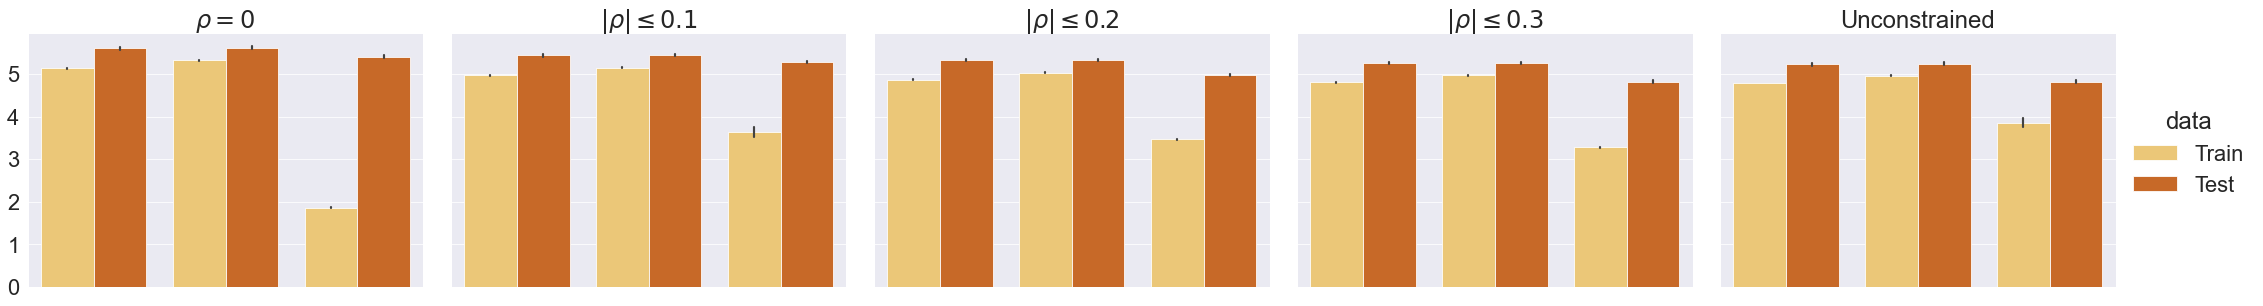

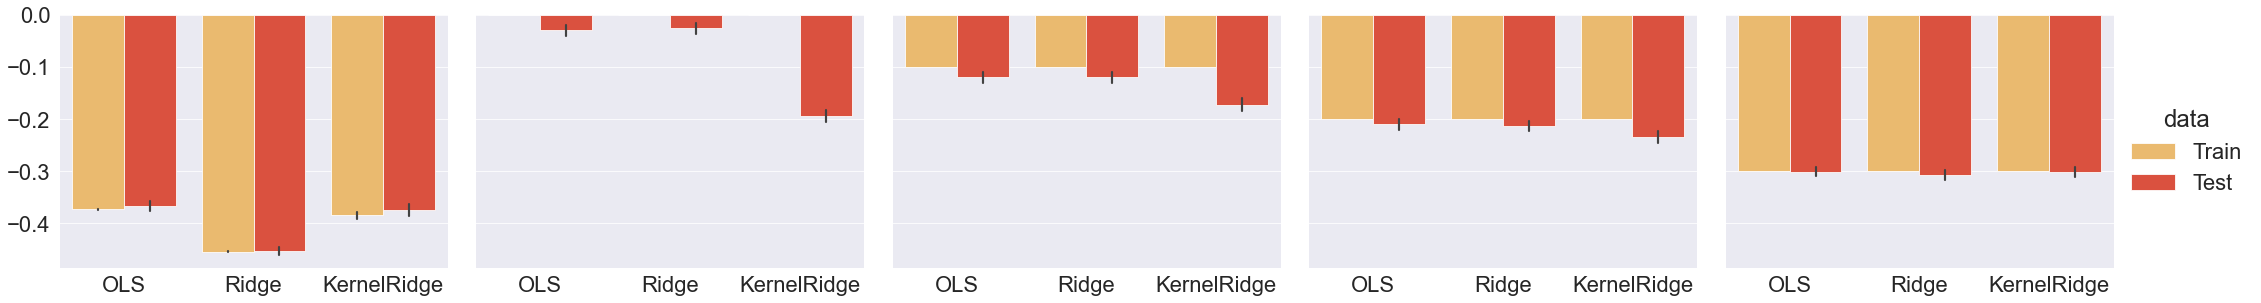

In [82]:
pal = "YlOrBr"
pal2= "YlOrRd"
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    
    # MSE
    g = sns.catplot(x="model", y="MAE",
                    hue="data", col="constraint",
                    data=df_mae,
                    orient="v", height=5, aspect=1.2, palette=pal,
                    kind="bar")
    g.set_titles("{col_name}")
    g.set_axis_labels("","")
#     g.set_axis_labels("")
    g.set_xticklabels("")
#     g.set_yticklabels("")
    plt.savefig(figdir + 'Fig_PAC_Results_MAE.png', dpi=200)
    
    # ADC
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="ADC",
                    hue="data", col="constraint",
                    data=df_corr, 
                    orient="v", height=5, aspect=1.2, palette=pal2,
                    kind="bar")
    g.set_titles("")
    g.set_axis_labels("","")
#     g.set_yticklabels("")
    plt.savefig(figdir + 'Fig_PAC_Results_ADC.png', dpi=200)

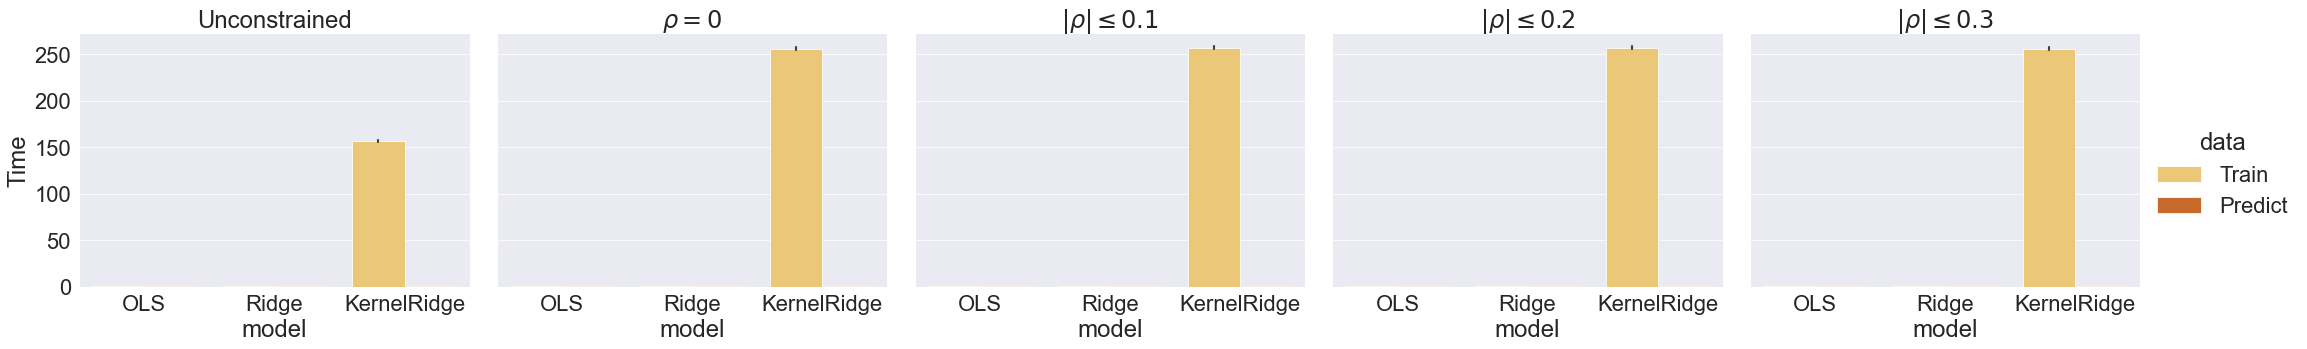

In [13]:
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="Time",
                    hue="data", col="constraint",
                    data=df_time,
                    orient="v", height=5, aspect=1.2, palette="YlOrBr",
                    kind="bar") #, dodge=False, cut=1, bw=3.2)
    g.set_titles("{col_name}")

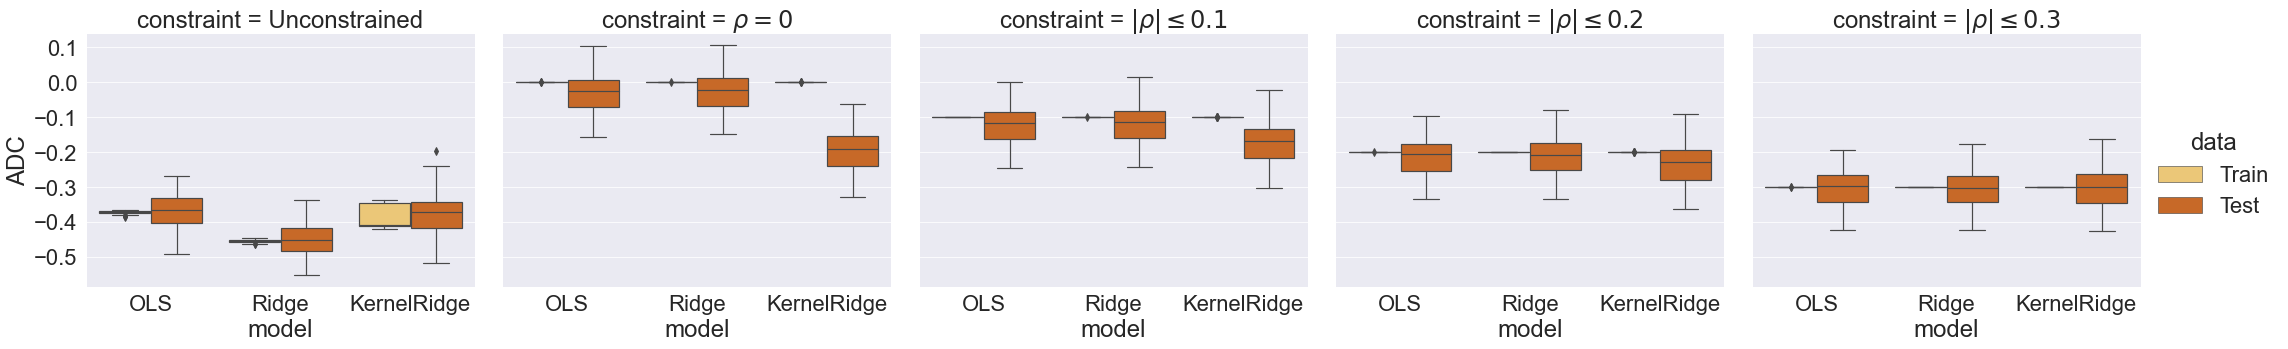

In [14]:
with sns.plotting_context("paper", font_scale=2.5):  # notebook paper slides
    sns.set_style("darkgrid")
    g = sns.catplot(x="model", y="ADC",
                    hue="data", col="constraint",
                    data=df_corr,
                    orient="v", height=5, aspect=1.2, palette="YlOrBr",
                    kind="box")

### Present timing results as pivot table

In [16]:
# bring categories in right order
df_time['constraint'] = df_time['constraint'].astype('category').cat.reorder_categories(constraints)
df_time['model'] = df_time['model'].astype('category').cat.reorder_categories(('OLS', 'Ridge', 'KernelRidge'))
df_time['data'] = df_time['data'].astype('category').cat.reorder_categories(('Train', 'Predict'))

In [17]:
pd.pivot_table(df_time, values='TimeMix', columns='model', index=('data', 'constraint',), \
        aggfunc=np.mean)

model                            OLS      Ridge  KernelRidge
data    constraint                                          
Train   Unconstrained       6.873372  69.739756   156.253231
        $\rho=0$            7.601844  85.993716   255.870365
        $|\rho|\, ≤\, 0.1$  7.586234  86.004792   256.867552
        $|\rho|\, ≤\, 0.2$  7.651907  86.626113   256.890076
        $|\rho|\, ≤\, 0.3$  7.594670  86.010605   255.684689
Predict Unconstrained       0.550566   0.512147     0.105630
        $\rho=0$            0.348277   0.372689     0.104926
        $|\rho|\, ≤\, 0.1$  0.346249   0.372923     0.106221
        $|\rho|\, ≤\, 0.2$  0.347282   0.376114     0.105102
        $|\rho|\, ≤\, 0.3$  0.345423   0.373657     0.105819

In [18]:
# different layout
# MEAN time
pv = pd.pivot_table(df_time, values='TimeMix', columns=('data','model'), index='constraint', \
        aggfunc=np.mean)
pv

data                   Train                          Predict            \
model                    OLS      Ridge KernelRidge       OLS     Ridge   
constraint                                                                
Unconstrained       6.873372  69.739756  156.253231  0.550566  0.512147   
$\rho=0$            7.601844  85.993716  255.870365  0.348277  0.372689   
$|\rho|\, ≤\, 0.1$  7.586234  86.004792  256.867552  0.346249  0.372923   
$|\rho|\, ≤\, 0.2$  7.651907  86.626113  256.890076  0.347282  0.376114   
$|\rho|\, ≤\, 0.3$  7.594670  86.010605  255.684689  0.345423  0.373657   

data                            
model              KernelRidge  
constraint                      
Unconstrained         0.105630  
$\rho=0$              0.104926  
$|\rho|\, ≤\, 0.1$    0.106221  
$|\rho|\, ≤\, 0.2$    0.105102  
$|\rho|\, ≤\, 0.3$    0.105819

In [19]:
print(pv.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
data & \multicolumn{3}{l}{Train} & \multicolumn{3}{l}{Predict} \\
model &   OLS & Ridge & KernelRidge &     OLS & Ridge & KernelRidge \\
constraint         &       &       &             &         &       &             \\
\midrule
Unconstrained      &  6.87 & 69.74 &      156.25 &    0.55 &  0.51 &        0.11 \\
\$\textbackslash rho=0\$           &  7.60 & 85.99 &      255.87 &    0.35 &  0.37 &        0.10 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.1\$ &  7.59 & 86.00 &      256.87 &    0.35 &  0.37 &        0.11 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.2\$ &  7.65 & 86.63 &      256.89 &    0.35 &  0.38 &        0.11 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.3\$ &  7.59 & 86.01 &      255.68 &    0.35 &  0.37 &        0.11 \\
\bottomrule
\end{tabular}



In [21]:
# STD time
pv_std = pd.pivot_table(df_time, values='TimeMix', columns=('data','model'), index='constraint', \
        aggfunc=np.std)
pv_std

data                   Train                         Predict            \
model                    OLS     Ridge KernelRidge       OLS     Ridge   
constraint                                                               
Unconstrained       0.358852  3.050508    6.413342  0.017651  0.019564   
$\rho=0$            0.414206  3.988540    7.594571  0.014771  0.016740   
$|\rho|\, ≤\, 0.1$  0.325022  3.206198    9.810065  0.012687  0.014556   
$|\rho|\, ≤\, 0.2$  0.452544  4.715076    9.958638  0.014762  0.019035   
$|\rho|\, ≤\, 0.3$  0.281118  2.434453    6.917019  0.012522  0.014918   

data                            
model              KernelRidge  
constraint                      
Unconstrained         0.007975  
$\rho=0$              0.006189  
$|\rho|\, ≤\, 0.1$    0.009209  
$|\rho|\, ≤\, 0.2$    0.006146  
$|\rho|\, ≤\, 0.3$    0.008189

In [22]:
print(pv_std.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrr}
\toprule
data & \multicolumn{3}{l}{Train} & \multicolumn{3}{l}{Predict} \\
model &   OLS & Ridge & KernelRidge &     OLS & Ridge & KernelRidge \\
constraint         &       &       &             &         &       &             \\
\midrule
Unconstrained      &  0.36 &  3.05 &        6.41 &    0.02 &  0.02 &        0.01 \\
\$\textbackslash rho=0\$           &  0.41 &  3.99 &        7.59 &    0.01 &  0.02 &        0.01 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.1\$ &  0.33 &  3.21 &        9.81 &    0.01 &  0.01 &        0.01 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.2\$ &  0.45 &  4.72 &        9.96 &    0.01 &  0.02 &        0.01 \\
\$|\textbackslash rho|\textbackslash , ≤\textbackslash , 0.3\$ &  0.28 &  2.43 &        6.92 &    0.01 &  0.01 &        0.01 \\
\bottomrule
\end{tabular}



### Statistical analysis of MAE results

1. For each model (Linear, Ridge, Kernel Ridge) and each data (Train, Test) run a regression of MAE on $\rho$.
2. Compare MAE between unconstrained and constrained models using Wilcoxon signed rank test.

In [88]:
5.258511/5.232129 * 100

100.50423068697276

In [83]:
df_mae.groupby(['data','model','constraint'])['MAE'].mean()

data   model        constraint        
Test   KernelRidge  $\rho=0$              5.411747
                    $|\rho|\, ≤\, 0.1$    5.287335
                    $|\rho|\, ≤\, 0.2$    4.981352
                    $|\rho|\, ≤\, 0.3$    4.822875
                    Unconstrained         4.825125
       OLS          $\rho=0$              5.612881
                    $|\rho|\, ≤\, 0.1$    5.447611
                    $|\rho|\, ≤\, 0.2$    5.331564
                    $|\rho|\, ≤\, 0.3$    5.258511
                    Unconstrained         5.232129
       Ridge        $\rho=0$              5.626096
                    $|\rho|\, ≤\, 0.1$    5.453443
                    $|\rho|\, ≤\, 0.2$    5.335108
                    $|\rho|\, ≤\, 0.3$    5.262207
                    Unconstrained         5.246881
Train  KernelRidge  $\rho=0$              1.860373
                    $|\rho|\, ≤\, 0.1$    3.639319
                    $|\rho|\, ≤\, 0.2$    3.469250
                    $|\rho|\, ≤\, 0.3$    3

In [84]:
import statsmodels.api as sm
from scipy.stats import wilcoxon, ranksums

# remove the unconstrained data and turn rho's into float
mae = df_mae.copy()
mae.constraint = mae.constraint.astype('category')
mae['constraint'] = mae['constraint'].astype('category').cat.rename_categories([0, 0.1, 0.2, 0.3, -1]).astype('float')

mae_train = mae[mae['data']=='Train']
mae_test = mae[mae['data']=='Test']

In [85]:
# run regression and print p-value
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    for px, data in enumerate(('Train', 'Test')):
        fit = sm.OLS.from_formula('MAE ~ constraint', data=mae[(mae.constraint!=-1)&(mae.model==model)&(mae.data==data)]).fit()
        print(f"{model} {data}: beta={fit.params['constraint']:.2f} p={fit.pvalues['constraint']:.4f}")

OLS Train: beta=-1.11 p=0.0000
OLS Test: beta=-1.18 p=0.0000
Ridge Train: beta=-1.18 p=0.0000
Ridge Test: beta=-1.21 p=0.0000
KernelRidge Train: beta=4.08 p=0.0000
KernelRidge Test: beta=-2.07 p=0.0000


In [86]:
# Signed-rank tests on test data
print('MAE on Train vs Test data:', wilcoxon(mae[mae['data']=='Train'].MAE, mae[mae['data']=='Test'].MAE))
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    mae_model = mae_test[mae_test['model']==model]
    print('\n', model, '\n----------')
    print(f'Unconstrained vs rho=0:', wilcoxon(mae_model[mae_model['constraint']==-1].MAE, \
                                                        mae_model[mae_model['constraint']==0].MAE))
    print(f'Unconstrained vs rho=0.1:', wilcoxon(mae_model[mae_model['constraint']==-1].MAE, \
                                                        mae_model[mae_model['constraint']==0.1].MAE))
    print(f'Unconstrained vs rho=0.2:', wilcoxon(mae_model[mae_model['constraint']==-1].MAE, \
                                                        mae_model[mae_model['constraint']==0.2].MAE))
    print(f'Unconstrained vs rho=0.3:', wilcoxon(mae_model[mae_model['constraint']==-1].MAE, \
                                                        mae_model[mae_model['constraint']==0.3].MAE))

MAE on Train vs Test data: WilcoxonResult(statistic=5101.0, pvalue=2.6117415995598185e-242)

 OLS 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=1.0, pvalue=4.0161556854627e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=26.0, pvalue=8.519072542858556e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=274.0, pvalue=9.967579141863275e-15)

 Ridge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=14.0, pvalue=5.94331234302936e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=290.0, pvalue=1.534086101076588e-14)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=1636.0, pvalue=0.002238099402043779)

 KernelRidge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559

### Statistical analysis of ADC results

1. For each model (Linear, Ridge, Kernel Ridge) and each data (Train, Test) run a regression of ADC on $\rho$.
2. Compare ADC between unconstrained and constrained models using Wilcoxon signed rank test.

In [60]:
df_corr.groupby(['data','model','constraint'])['ADC'].mean()

data   model        constraint        
Test   KernelRidge  $\rho=0$             -1.940492e-01
                    $|\rho|\, ≤\, 0.1$   -1.728196e-01
                    $|\rho|\, ≤\, 0.2$   -2.342252e-01
                    $|\rho|\, ≤\, 0.3$   -3.011724e-01
                    Unconstrained        -3.742062e-01
       OLS          $\rho=0$             -2.990349e-02
                    $|\rho|\, ≤\, 0.1$   -1.202163e-01
                    $|\rho|\, ≤\, 0.2$   -2.102897e-01
                    $|\rho|\, ≤\, 0.3$   -3.006398e-01
                    Unconstrained        -3.671701e-01
       Ridge        $\rho=0$             -2.576658e-02
                    $|\rho|\, ≤\, 0.1$   -1.199326e-01
                    $|\rho|\, ≤\, 0.2$   -2.137197e-01
                    $|\rho|\, ≤\, 0.3$   -3.074617e-01
                    Unconstrained        -4.530759e-01
Train  KernelRidge  $\rho=0$             -6.371191e-14
                    $|\rho|\, ≤\, 0.1$   -1.000000e-01
                    $|\rho

In [61]:
import statsmodels.api as sm
from scipy.stats import wilcoxon, ranksums

# remove the unconstrained data and turn rho's into float
corr = df_corr.copy()
corr.constraint = corr.constraint.astype('category')
corr['constraint'] = corr['constraint'].astype('category').cat.rename_categories([0, 0.1, 0.2, 0.3, -1]).astype('float')

corr_train = corr[corr['data']=='Train']
corr_test = corr[corr['data']=='Test']

In [67]:
# run regression and print p-value
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    for px, data in enumerate(('Train', 'Test')):
        fit = sm.OLS.from_formula('ADC ~ constraint', data=corr[(corr.constraint!=-1)&(corr.model==model)&(corr.data==data)]).fit()
        print(f"{model} {data}: beta={fit.params['constraint']:.2f} p={fit.pvalues['constraint']:.4f}")

OLS Train: beta=-1.00 p=0.0000
OLS Test: beta=-0.90 p=0.0000
Ridge Train: beta=-1.00 p=0.0000
Ridge Test: beta=-0.94 p=0.0000
KernelRidge Train: beta=-1.00 p=0.0000
KernelRidge Test: beta=-0.38 p=0.0000


In [66]:
# Signed-rank tests on test data
print('ADC on Train vs Test data:', wilcoxon(corr_train.ADC, corr_test.ADC))
for mx, model in enumerate(('OLS', 'Ridge', 'KernelRidge')):
    corr_model = corr_test[corr_test['model']==model]
    print('\n', model, '\n----------')
    print(f'Unconstrained vs rho=0:', wilcoxon(corr_model[corr_model['constraint']==-1].ADC, \
                                                        corr_model[corr_model['constraint']==0].ADC))
    print(f'Unconstrained vs rho=0.1:', wilcoxon(corr_model[corr_model['constraint']==-1].ADC, \
                                                        corr_model[corr_model['constraint']==0.1].ADC))
    print(f'Unconstrained vs rho=0.2:', wilcoxon(corr_model[corr_model['constraint']==-1].ADC, \
                                                        corr_model[corr_model['constraint']==0.2].ADC))
    print(f'Unconstrained vs rho=0.3:', wilcoxon(corr_model[corr_model['constraint']==-1].ADC, \
                                                        corr_model[corr_model['constraint']==0.3].ADC))

ADC on Train vs Test data: WilcoxonResult(statistic=351017.0, pvalue=1.50921277164279e-36)

 OLS 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)

 Ridge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.2: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.3: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)

 KernelRidge 
----------
Unconstrained vs rho=0: WilcoxonResult(statistic=0.0, pvalue=3.896559845095909e-18)
Unconstrained vs rho=0.1: WilcoxonResult(statistic=0.0, pvalue=3.896559845095

<a id="other"></a>
# Other/old
[back to top](#top)

<a id="statsmodels"></a>
## Statsmodels
[back to top](#top)

In [ ]:
from statsmodels.regression.linear_model import OLS, OLSResults, RegressionResultsWrapper

class OLSCC(OLS):
    def __init__(self, endog, exog=None, missing='none', hasconst=None, rho=0,
                 **kwargs):
        super(OLSCC, self).__init__(endog, exog, missing=missing,
                                  hasconst=hasconst, **kwargs)
        if "weights" in self._init_keys:
            self._init_keys.remove("weights")
        self.rho = rho
        
    def fit(self, method="pinv", cov_type='nonrobust', cov_kwds=None,
            use_t=None, **kwargs):
        # see fit method in class RegressionModel in:
        # https://github.com/statsmodels/statsmodels/blob/master/statsmodels/regression/linear_model.py
        results = super().fit(method, cov_type, cov_kwds, use_t, **kwargs)

        if self.rho is not None:
            # scale beta to fulfill correlation constraint
            X, y = self.exog, self.endog
            beta = results.params
            
            # check whether there is an intercept
            intercept_ix = None
            if np.all(X[:, 0] == 1):
                intercept_ix = 0
            elif np.all(X[:, -1] == 1):
                intercept_ix = X.shape[1]
            elif not(np.all(np.isclose(y.mean(), 0)) and np.all(np.isclose(X.mean(axis=0), 0))):
                raise ValueError('endog must contain an intercept term or predictors and responses need to be centered')

            yc = y - y.mean()
            yhat = results.fittedvalues - results.fittedvalues.mean()
            if self.rho == 0:
                # calculate correction factor a
                a = yc.dot(yc) / yhat.dot(yhat) 
            else:
                # set corr(y, y - yhat) to rho or -rho
                y2 = yc.dot(yc)
                yhat2 = yhat.dot(yhat)
                yyhat = yc.dot(yhat)
                rho2 = self.rho**2
                c = yyhat**2 - rho2*y2*yhat2

                # since we use a square to solve for a we get two solutions
                # one gives us corr(y,e) = rho, the other corr(y,e) = -rho
                a1 = y2 * yyhat * (1-rho2)/c - y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
                a2 = y2 * yyhat * (1-rho2)/c + y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
                a = a1

            # applt a to non-intercept elements of beta
            beta_ix = np.setdiff1d(np.array(range(X.shape[1]), dtype=np.int), intercept_ix)
            beta[beta_ix] *= a

            # fix intercept
            if intercept_ix is not None:
                mx = X[:, beta_ix].mean(axis=0)
                beta[intercept_ix] = y.mean() - mx.dot(beta[beta_ix])

            lfit = OLSResults(
                self, beta,
                normalized_cov_params=self.normalized_cov_params,
                cov_type=cov_type, cov_kwds=cov_kwds, use_t=use_t)
            
            results = RegressionResultsWrapper(lfit)
            results.a = a
            
        return results

In [ ]:
model = sm.OLS(y, X).fit()
model_cc = OLSCC(y, X, rho=0.01).fit()

In [ ]:
model_cc.params

In [ ]:
np.corrcoef(y, y-model.fittedvalues)[0,1]

In [ ]:
np.corrcoef(y, y-model_cc.fittedvalues)[0,1]

In [ ]:
model.summary()

In [ ]:
model_cc.summary()

In [ ]:
# plot y against e
plt.subplot(121)
plt.plot(y, model.fittedvalues, '.')
plt.plot(plt.xlim(), plt.ylim(), '-')
plt.title(f'OLS corr={np.corrcoef(y, model.resid)[0,1]:1.4f}')

plt.subplot(122)
# plt.plot(y, model_cc.fittedvalues, '.')
plt.plot(y, y - model_cc.resid, '.')
plt.plot(plt.xlim(), plt.ylim(), '-')
plt.title(f'OLSCC with a={model_cc.a:.4f} corr={np.corrcoef(y, model_cc.resid)[0,1]:1.4f}')

In [ ]:
# only plot e
fig = plt.figure(figsize=(8, 3))
plt.subplot(121)
plt.plot(model.resid)
plt.plot(plt.xlim(), [0,0], '-')
plt.title('OLS')

plt.subplot(122)
plt.plot(model_cc.resid)
plt.plot(plt.xlim(), [0,0], '-')
plt.title('OLSCC')


In [ ]:
model_cc.a

In [ ]:
# y - model.fittedvalues
model.resid_pearson

<a id="calc_inequality"></a>
### Numerically check derivation for bounded correlation constraint

[back to top](#top)

In [ ]:
from numpy.linalg import norm
ny = norm(y)**2
nyhat = norm(yhat)**2
rho2 = 0.1**2
a = 1.1
a2 = a*a
yyhat = y.dot(yhat)
# start

(y.dot(y) - y.dot(a*yhat))**2 - rho2* (norm(y)*norm(y-a*yhat))**2

In [ ]:
ny**2 - 2*a*ny*y.dot(yhat) + a2*(y.dot(yhat))**2 - rho2 * ny * norm(y-a*yhat)**2
ny**2 - 2*a*ny*y.dot(yhat) + a2*(y.dot(yhat))**2 - rho2 * ny * (ny-2*a*y.dot(yhat)+a2*nyhat)

In [ ]:
# (II)
# a2* (yyhat)**2 - a2*rho2*ny*nyhat - 2*a*ny*yyhat + 2*a*rho2*ny*yyhat + ny**2 - rho2*ny**2
(a2* (yyhat**2 - rho2*ny*nyhat) - 2*a*ny*yyhat * (1-rho2) + ny**2 * (1-rho2))

In [ ]:
# (IV)
c = y.dot(yhat)**2 - rho2 * y.dot(y) * yhat.dot(yhat)
print(c)

print(a2 - 2*a*ny*yyhat * (1-rho2)/c + ny**2 * (1-rho2)/c )

In [ ]:
# (V)
np.sqrt((a - ny * yyhat *(1-rho2)/c)**2 - ny**2 * yyhat**2 * (1-rho2)**2 / c**2 + ny**2 * (1-rho2)/c)

In [ ]:
# solution
a1 = ny * yyhat * (1-rho**2)/c   + ny/c * np.sqrt( rho2 * (1-rho2) * (ny*nyhat - yyhat))
a2 = ny * yyhat * (1-rho**2)/c   - ny/c * np.sqrt( rho2 * (1-rho2) * (ny*nyhat - yyhat))
print(a1, a2)

In [ ]:
H = X @ inv(X.T@X + 1*np.eye(X.shape[1])) @ X.T 
beta = inv(X.T@X) @ X.T @ y
yhat = X@beta
print(beta)

## ---

In [ ]:
def calc_a(y, yhat, rho):
    y2 = y.dot(y)
    yhat2 = yhat.dot(yhat)
    yyhat = y.dot(yhat)
    rho2 = rho**2
    
    c = yyhat**2 - rho2*y2*yhat2

    # since we use a square to solve for a we get two solutions
    # one gives us corr(y,e) = rho, the other corr(y,e) = -rho
    a1 = y2 * yyhat * (1-rho2)/c   - y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
    a2 = y2 * yyhat * (1-rho2)/c   + y2/c * np.sqrt( rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))
    return a1, a2

In [ ]:
a1, a2 = calc_a(yc, yhatc, 0.3)
print(a1, a2, a)
np.corrcoef(yc, yc-yhatc*a1)[0,1], np.corrcoef(yc, yc-yhatc*a2)[0,1], np.corrcoef(yc, yc-yhatc*a)[0,1]

In [ ]:
# set correlation = 0.1
a = 1.108967246216836621
np.corrcoef(yc, yc-yhatc*a)[0,1]

In [ ]:
y2 = yc.dot(yc)
yhat2 = yhatc.dot(yhatc)
yyhat = yc.dot(yhatc)
rho2 = rho**2
a2 = a**2
e = yc-yhatc*a

In [ ]:
yc.dot(e)/(np.sqrt(yc.dot(yc)*x.dot(x)))

In [ ]:
# try to check the derivation of the formula : to this end a has been set, 
# the result of every line should be close to 0
# correlation formula
(y2 - yyhat * a) - rho * (np.sqrt(y2 * e.dot(e)))

In [ ]:
# after squaring and resolving some brackets
y2**2 - 2*a*y2*yyhat + a2*yyhat**2 - rho2 * y2 * (y2 - 2*a*yyhat + a2*yhat2)
# y2**2 - 2*a*y2*yyhat + a2*yyhat**2 - rho2 * y2 * e.dot(e)

In [ ]:
# bringing it one one side
a**2 * (yyhat**2 - rho2 * y2 * yhat2) - 2*a*y2*yyhat*(1-rho2) + y2**2*(1-rho2)

In [ ]:
# dividing by c
c = yyhat**2 - rho2 * y2 * yhat2
(a**2 - 2*a*y2*yyhat*(1-rho2)/c + y2**2*(1-rho2)/c)*c

In [ ]:
# quadratische ergaenzung
(a - y2*yyhat*(1-rho2)/c)**2 + y2**2*(1-rho2)/c - y2**2 * yyhat**2 * (1-rho2)**2/(c**2)

In [ ]:
# quadratische ergaenzung
(a - y2*yyhat*(1-rho2)/c)**2 - y2**2/(c**2) * (rho2 * (1-rho2) * (y2*yhat2 - yyhat**2))

In [ ]:
# double-check limited correlation constraint
np.corrcoef(yc, yc - yhatc*a1)[0,1], np.corrcoef(yc, yc - yhatc*a2)[0,1]


<a id="iris_example"></a>
### Iris example data
[back to top](#top)


In [ ]:
iris = sns.load_dataset("iris")
iris.iloc[:, :4] += [1,2,3,-10]
iris.head()

In [ ]:
X = iris.iloc[:, :3].to_numpy().copy()
y = iris.iloc[:, -2].to_numpy().copy()
y.mean()

In [ ]:
inv(X.T@X)

In [ ]:
Xm = X - X.mean(axis=0)
Xm.T @ Xm

In [ ]:
mx = np.expand_dims(X.mean(axis=0),-1)

X.T @ X - X.shape[0] *mx @ mx.T

In [ ]:
use_intercept = True
# use_intercept = False

if use_intercept:
    # add constant
    print('Adding constant term to X')
    X = sm.add_constant(X)
#     print(X[:8, :])
else:
    # center X and y
    print('Centering X and y')
    X -= X.mean(axis=0)
    y -= y.mean()

In [ ]:
yhat, beta, H = OLS_solution(y, X)

print(beta)
print(f'OLS corr(y,e): {np.corrcoef(y,y-yhat)[0,1]:.4f}')

In [ ]:
yhat, beta, H = ridge_solution(y, X, l=.1, use_intercept=use_intercept)
print(beta)
print(f'Ridge corr(y,e): {np.corrcoef(y,y-yhat)[0,1]:.4f}')

In [ ]:
yhat, beta, H = ridge_solution(y, X, l=0.1, use_intercept=use_intercept)
print(beta)

In [ ]:
yhat, K, H = kernel_ridge_solution(y, X, l=0.1, gamma=.1)
print(beta)
print(f'Kernel Ridge corr(y,e): {np.corrcoef(y,y-yhat)[0,1]:.4f}')